# Voronoi Diagram

A Voronoi diagram is a partition of a plane into regions close to each of a given set of objects. In the simplest case, these objects are just finitely many points in the plane (called seeds, sites, or generators). For each seed there is a corresponding region, called a Voronoi cell, consisting of all points of the plane closer to that seed than to any other. 
The code below is the implementation of the simplest case.

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.distance import cdist,pdist,squareform
import matplotlib.tri as tri

import warnings
# We do this to ignore several specific warnings
warnings.filterwarnings('ignore')

In [108]:
def voronoi(X,Y):
    """
    Voronoi diagram from a list of points
    Copyright (C) 2011  Nicolas P. Rougier
    """
    P = np.zeros((X.size+4,2))
    P[:X.size,0], P[:Y.size,1] = X, Y
    # We add four points at "infinity"
    m = max(np.abs(X).max(), np.abs(Y).max())*1e5
    P[X.size:,0] = -m, -m, +m, +m
    P[Y.size:,1] = -m, +m, -m, +m
    D = matplotlib.tri.Triangulation(P[:,0],P[:,1])
    T = D.triangles
    n = T.shape[0]
    C = np.zeros((n,2))
    for i in range(n):
        C[i] = circumcircle(P[T[i,0]],P[T[i,1]],P[T[i,2]])
    X,Y = C[:,0], C[:,1]
    segments = []
    for i in range(n):
        for j in range(3):
            k = D.neighbors[i][j]
            if k != -1:
                segments.append( [(X[i],Y[i]), (X[k],Y[k])] )
    return segments

In [109]:
def circumcircle(P1,P2,P3):
    ''' 
    Adapted from:
    http://local.wasp.uwa.edu.au/~pbourke/geometry/circlefrom3/Circle.cpp
    '''
    delta_a = P2 - P1
    delta_b = P3 - P2
    if np.abs(delta_a[0]) <= 0.000000001 and np.abs(delta_b[1]) <= 0.000000001:
        center_x = 0.5*(P2[0] + P3[0])
        center_y = 0.5*(P1[1] + P2[1])
    else:
        aSlope = delta_a[1]/delta_a[0]
        bSlope = delta_b[1]/delta_b[0]
        if np.abs(aSlope-bSlope) <= 0.000000001:
            return None
        center_x= (aSlope*bSlope*(P1[1] - P3[1]) + bSlope*(P1[0] + P2 [0]) \
                        - aSlope*(P2[0]+P3[0]) )/(2* (bSlope-aSlope) )
        center_y = -1*(center_x - (P1[0]+P2[0])/2)/aSlope +  (P1[1]+P2[1])/2;
    return center_x, center_y

In [110]:
def plot_voronoi(k, N, m, n):
    """
    Adapted from Joshua Adelman (https://github.com/synapticarbors)
    
    Code to take a voronoi tesselation of a 2D space and subdivide each voronoi cell by 
    selecting the m furthest neighboring voronoi cell centers and generating n-1 new points between
    the center and the midpoint to the neighbor, that along with the original center will 
    define a new voronoi partition within the cell.
    
    Parameters
    ----------
    k: number of reference poses
    N: number of test points
    m: number of neighbors to base subdivision off of
    n: number of slices 
    """
    
    colors = np.arange(m*n+1)

    g = np.linspace(0,1,n+1)
    gdata = np.array([0,1])

    # Define Random reference points
    x_i = np.random.uniform(0,5,size=(k,2))

    # Calculate pairwise distance between references points
    d_ij = squareform(pdist(x_i))

    # Define voronoi
    vorbounds = voronoi(x_i[:,0],x_i[:,1])
        
    # Create Deluanay Triangulation
    triang = tri.Triangulation(x_i[:,0], x_i[:,1])
    edges = triang.edges

    # Create supplementary poses to subdivide voronoi cells
    y_i = []
    for vori,vor in enumerate(x_i):
        temppoints = []
        # Identify neighboring reference poses
        jj = np.where((edges[:,0] == vori) | (edges[:,1] == vori))
        pj = edges[jj].flatten()
        pj = pj[pj != vori]
        
        # Get m poses with largest distance
        d_j = d_ij[vori,:]
        neigh_target_j = pj[np.argsort(d_j[pj])[::-1]]
        
        # Linearly interpolate n points between reference and midpoint with neighbors
        count = 0
        for nj in neigh_target_j:
            if count > m - 1:
                break
            midpoint = 0.5*(vor - x_i[nj,:]) + x_i[nj,:]
            nearest = np.argmin(cdist(np.atleast_2d(midpoint),x_i))
            # exclude centeres connected via the Delaunay triangulation
            # that pass through an intervening voronoi cell
            if not nearest in [nj,vori]:
                continue
            endpoints = np.vstack((vor,midpoint))
            a = np.zeros((g.shape[0]-2,2))
            for dim in range(2):
                a[:,dim] = np.interp(g,gdata,endpoints[:,dim])[1:-1]
            
            temppoints.append(a)
            count += 1
        
        if len(temppoints):  
            y_i.append(np.vstack(temppoints))
        else:
            y_i.append([])

    # Generate a large number of random configs and assign to subdivisions
    x = np.random.uniform(0,5,size=(N,2))
    cassign = np.zeros((N,))
    for ii,p in enumerate(x):
        # Calculate the distance from point to every reference pose
        p = np.atleast_2d(p)
        d_j = cdist(p,x_i,metric='euclidean')
        
        # Identify voronoi membership
        pi = np.argmin(d_j)
        
        # Determine membership in subdivisions
        if len(y_i[pi]):
            subpoints = np.vstack((x_i[pi,:],y_i[pi]))
        else:
            subpoints = x_i[pi,:]
        subpoints = np.atleast_2d(subpoints)
        si = np.argmin(cdist(p,subpoints))
        cassign[ii] = colors[si]
        
    #print cassign    
    fig = plt.figure(facecolor = 'mistyrose', figsize=(10,10))
    ax = fig.add_subplot(111)

    # Plot reference poses
    ax.plot(x_i[:,0],x_i[:,1],'.',color='gold',markersize=22)

    # Plot internal points
    y_ii = [a for a in y_i if a != []]
    z = np.vstack(y_ii)
    ax.plot(z[:,0],z[:,1],'.',color='gold',markersize=15)


    # Plot voronoi edges
    vorlines = matplotlib.collections.LineCollection(vorbounds, color='gold',linewidths=6)
    ax.add_collection(vorlines)

    # Plot Deluanay triangulation
    ax.triplot(triang, 'wo-')

    # Plot test particles
    ax.scatter(x[:,0],x[:,1],marker='o',c=cassign,s=5, cmap='magma')
    plt.axis([-0.5,5.5,-.5,5.5])
    plt.axis('off')
    plt.show()
    

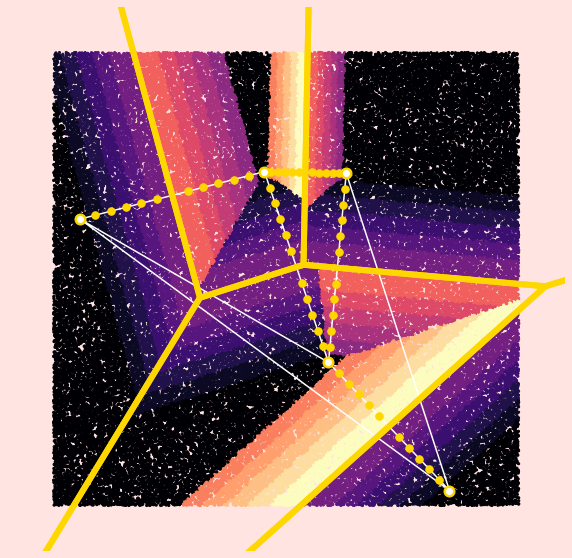

In [111]:
k = 5 # number of reference poses
N = 80000 # number of test points
m = 3 # number of neighbors to base subdivision off of
n = 6 # number of slices 

plot_voronoi(k, N, m, n)

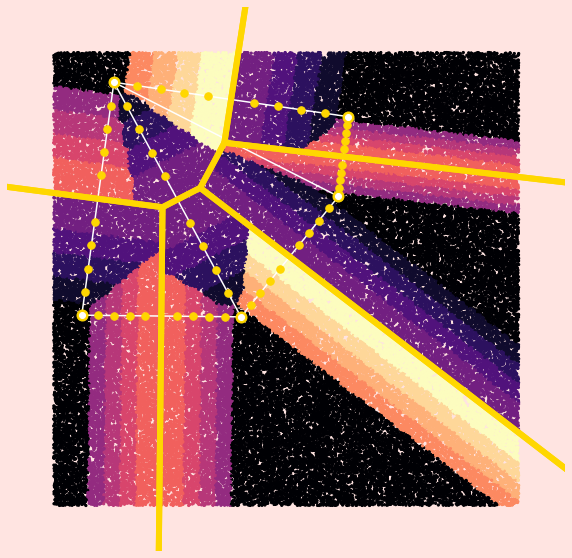

In [112]:
k = 5 # number of reference poses
N = 80000 # number of test points
m = 4 # number of neighbors to base subdivision off of
n = 5 # number of slices 

plot_voronoi(k, N, m, n)